# Evaluación de la pérdida de calidad del audio usando el codec Opus en tareas de auscultación remota

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Agosto 2020 · 10 min read

---

## Resumen

Con el auge actual de la tele-medicina, la industria médica se ha dedicado al desarrollo de estetoscopios digitales con el fin suplir la demanda de hospitales y clínicas que buscan auscultar a sus pacientes remotamente. El desarrollo de estos aparatos no involucra solamente la construcción del hardware y del software, sino también en desarrollar la infraestructura necesaria para transferir los datos hacia los médicos o los servidores que corren los algoritmos de reconocimiento de patrones. De acuerdo a la literatura científica, parte de esta infraestructura involucra el uso del códec Opus, que también es empleado por plataformas de videollamada como Zoom, MS Teams y Skype. Opus, a pesar de ser uno de los mejores métodos de compresión de audio, es un algoritmo "con pérdida", lo que significa que altera el contenido frecuencial para que sea audible solo por el oído humano. Esta modificación deja en desventaja a los algoritmos de reconocimiento de patrones que podrían requerir analizar todo el espectro de la señal. En este ipython notebook analizamos la alteración que produce Opus a sonidos del corazón y los pulmones para determinar si la pérdida de la calidad aún con una tasa de bits de 128 kbps puede afectar a un algoritmos de reconocimiento de patrones. Los resultados obtenidos son preliminares, pero muestran que aplicando un filtrado pasa-bajas la distorsión es aceptable. 

![](img/2017-08-30-07-09-32.jpeg)

Figura 1. Tomada de https://pixnio.com/es/ciencia/ciencia-medica/estetoscopio-telefono-movil-diagnostico-pulso-cardiologia-medicina-atencion-medica.

# El códec Opus

En el 2013, durante la conferencia número 135 de la Audio Engineering Society, Valin et. al (cuatro desarrolladores de Microsoft y Mozilla) propusieron un códec de sonido llamado Opus, capaz de realizar una compresión del audio mejor que la que estaban realizando otros algoritmos del momento como el MP3, _Advance Audio Coding_ (AAC) y Vorbis. Opus superaba a estos algoritmos en términos de tamaño de la transmisión, retrasos de la señal (tan bajos como 5 ms), compatibilidad con tasas de bits (desde 8 kHz hasta 48 kHz), y manejo de ruidos transitorios. La figura 2 muestra que el códec Opus ofrece la misma calidad de audio pero a una menor tasa de bits, lo que permite ofrecer calidades mejores con el mismo ancho de banda, y es capaz de cubrir casi todo el rango de transmisión. El códec Opus se basa en dos algoritmos previos: [SILK](https://github.com/ploverlake/silk) para la compresión de voz (originalmente desarrollado por Skype), y *Constrained Energy Lapped Transform* (CELT), para la compresión de música; así como un modo híbrido [3, 4, 13].  

![](img/qualityOpus.png)

Figura 2. Rendimiento del algoritmo Opus (tomada del sitio de Opus https://opus-codec.org/static/comparison/quality.svg).

---
**Nota aclaratoria:** la razón por la cual elegimos estudiar al Opus es porque es el algoritmo predeterminado del framework WebRTC, porque es de código libre, y porque según la literatura científica ha sido empleado desde el 2015 en labores de telemedicina [19]. Igualmente, la teoría explicada aquí se puede aplicar a otros códecs de compresión del audio.

---

Al igual que otros algoritmos de compresión del audio, Opus es un algoritmo de compresión "con pérdida", lo que quiere decir que reduce el tamaño de las grabaciones eliminando información auditiva inaudible para el oído humano. Cuando hablamos del oído humano nos referimos más exactamente a la cóclea, que como muestra la figura 3, es un órgano en forma cónica encargado de percibir las frecuencias y transmitirlas como impulsos eléctricos al cerebro. La cóclea se encuentra "arrollada" dentro del oído interno y recibe estímulos del oído externo e intermedio mediante la ventana oval. La ventana oval se conecta a su vez con los huesecillos que reciben estímulos del tímpano y que flotan en un medio acuoso.

![](img/800px-Anatomy_of_the_Human_Ear.svg.png)

Figura 3. Tomada de https://en.wikipedia.org/wiki/Auditory_system#/media/File:Anatomy_of_the_Human_Ear.svg.

La cóclea, como explica la teoría psicoacústica, sufre dos efectos llamados _enmascaramiento frecuencial_ y _enmascaramiento temporal_ (el segundo lo omitiremos en este ipython notebook). El enmascaramiento frecuencial ocurre cuando dos tonos están lo suficientemente cercanos y el de mayor energía logra cubrir con su envolvente espectral al de menor energía, enmascarándolo. La figura 4 ilustra que este efecto solo se logra cuando ambos tonos comparten la misma _banda crítica_, que son 32 regiones en las que está dividida la cóclea, y que "resuenan" con mayor facilidad a una frecuencia característica. Dos ejemplos de bandas críticas son: $[0.5,0.7]$ kHz con frecuencia central de $0.5$ kHz y $[8.9,10.4]$ kHz con frecuencia central $9.6$ kHz [10].

![](img/QA_2-0112.jpeg)

Figura 4. Ilustración del audio interno, medio y externo (tomada de https://output.com/blog/9-sound-design-tips-to-hack-your-listeners-ears).  

La longitud y la localización de las bandas críticas han sido aproximadas en unas escalas numéricas llamadas Bark y ERB. Estas escalan se basan en el hecho de que el oído humano realiza un mejor trabajo diferenciando tonos graves que tonos agudos (como siguiendo una distribución logarítmica). La escala *Equivalent Rectangular Bandwidth* (ERB) es una versión mejorada de la escala Bark y su ecuación es la siguiente[9]: 

$$\text{ERB}(f)=21.4 \log_{10}{(0.00437f+1)}.$$

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


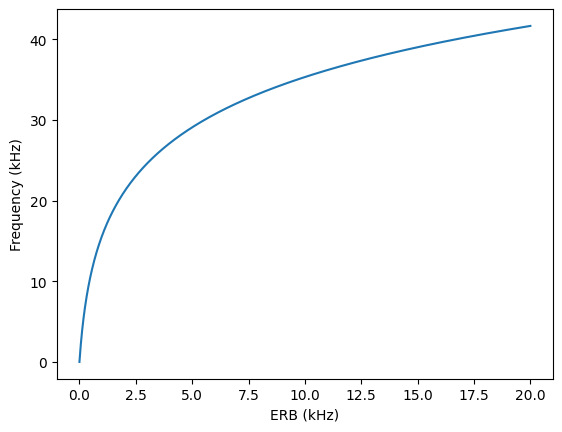

[    0    35    76   124   179   242   315   400   498   611   742   893
  1068  1270  1503  1772  2083  2443  2859  3339  3894  4536  5277  6134
  7123  8267  9589 11116 12881 14920 17276 20000]


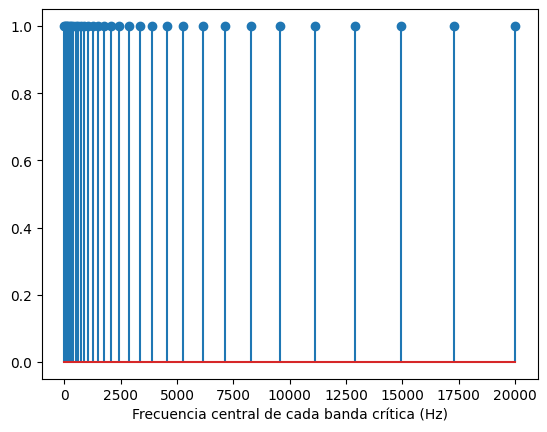

In [1]:
%pylab inline
import numpy as np

def erb(F):
    return 21.4 * np.log10(0.00437*F+1)

F = np.linspace(0,20000,1000) # 0 a 20k Hz es el rango de audición humana
E = erb(F)
pylab.plot(F/1e3,E)
pylab.ylabel('Frequency (kHz)')
pylab.xlabel('ERB (kHz)')
pylab.show()

E = np.linspace(0,erb(20000),32) # 32 puntos equidistantes
F = (np.power(10,E/21.4)-1)/0.00437 # invertimos el logaritmo de la escala ERB
print(F.astype(int))
pylab.stem(F,np.ones(len(F)))
pylab.xlabel('Frecuencia central de cada banda crítica (Hz)')
pylab.show()

# Una primera solución 

Como vimos en la sección anterior, el Opus destruye información frecuencial imitando la forma como el oído humano enmascara ciertas frecuencias en presencia de otras. Suponiendo que el estetoscopio utiliza el mismo canal de audio de la llamada, esto podría ser perjudicial para algoritmos de reconocimiento de patrones, porque en lugar de procesar datos en crudo (en formato WAV, por ejemplo), tendrían que procesar datos con ruido producido por la compresión (algo que sin embargo, un buen algoritmo debería tolerar). 

Una posible solución sería forzar una transmisión de audio sin ningún algoritmo de compresión de audio, pero eso significaría consumir $1.35~\text{Mbps}$ cada segundo ($1~\text{canal} \cdot 44100~\text{Hz} \cdot 32~\text{bits de cuantización } / (1024*1024)$). Lo que para una una clínica ubicada en una zona rural que utilice una conexión de 1.4 Mbps (el máximo permitido para 3.5G) significaría quedarse sin video durante la llamada [17]. Para ilustrar lo molesto que esto significaría, proponemos el siguiente diálogo imaginario entre una clínica y un médico:

> Médico (o el sistema): —Muy bien, vamos a realizar la auscultación. Clínica, apague su cámara (yo voy a apagar la mia). Muy bien, ahora espere un momento... voy a activar el modo "estetoscopio". Listo, proceda a colocar el estetoscopio digital en el espacio intercostal izquierdo de la línea medioclavicular e indíqueme para grabar.— 
>
> Clínica: —Listo doctor, el aparato está ubicado en la zona.—
>
> Médico: —Ok, no puedo ver, pero confío en que ubicó el aparato en la zona que le indiqué.—
>
> Clínica: —Listo doctor, puede comenzar a grabar.—
>
> Médico (1 minuto después): —Ok, ahora repitamos en esta otra zona...—

Terrible, ¿no es así?. Y confiemos que la clínica no va a recibir un correo electrónico que pueda cortar la transmisión mientras se está auscultando al paciente.

![](img/dt_140326_doctor_mistake_250x188.png)

Figura 5. Posiblemente, como se vería nuestro médico auscultando remotamente y sin video a nuestro paciente. Tomada de https://output.com/blog/9-sound-design-tips-to-hack-your-listeners-ears.   



# Evaluando al Opus a 8 y 128 kbps

Una alternativa a transmitir datos crudos y sufrir los inconvenientes descritos arriba es forzar al algoritmo Opus a comprimir y transmitir el audio con una tasa de bits de calidad más alta, digamos 128 kbps (full-band stereo). Veamos entonces si con esta tasa de bits la distorsión que produce Opus a sonidos del corazón y los pulmones es aceptable. Considerando que el rango de frecuencias deseado es de $[0.06, 1.0]$ kHz para los pulmones y $[0.02, 0.5]$ kHz para el corazón ($[0.02, 1.0]$ kHz en conjunto), luego de haber comprimido y descomprimido el audio, podemos definir los siguientes casos de prueba [14, 15]:<a href="#footnote-1"><sup>1</sup></a>

* Verificar que la magnitud espectral de un barrido de frecuencias de $[0.02,1]$ kHz mantenga la misma información, sin que el códec agregue o elimine frecuencias (caso de prueba 1).
* Verificar que para dos tonos con frecuencia $0.595$ kHz y $0.605$ kHz (ubicados en la misma banda crítica), solo el de $0.605$ kHz deberá escucharse si la energía del de $0.595$ kHz está por debajo de cierto umbral (caso de prueba 2).
* Verificar que para una señal real y cruda captada por un estetoscopio digital, no haya pérdida de información visible (caso de prueba 3).

## Caso de prueba 1

Para probar el caso de prueba #1 se puede utilizar un barrido de frecuencias como sigue [6]:<a href="#footnote-1"><sup>2</sup></a>
$$
F(t) = \Big(\frac{F_1-F_0}{T}\Big)t + F_0,
$$

donde el barrido puede ser construido usando un senoidal de la forma $x[t] = A \sin(2\pi Ft)$. El rango de frecuencias a usar es de $[0.02, 20]$ kHz (el rango de audición humana).

**Nota: a partir de este momento se recomienda bajar el volumen del audio si se están usando audífonos.**

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_16026/3682083402.py:24: SyntaxWarning: invalid escape sequence '\s'
  pylab.ylabel('$\sqrt{|S(f)|}$')


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


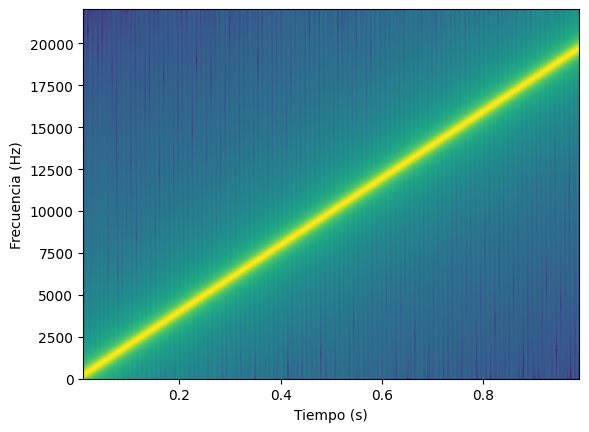

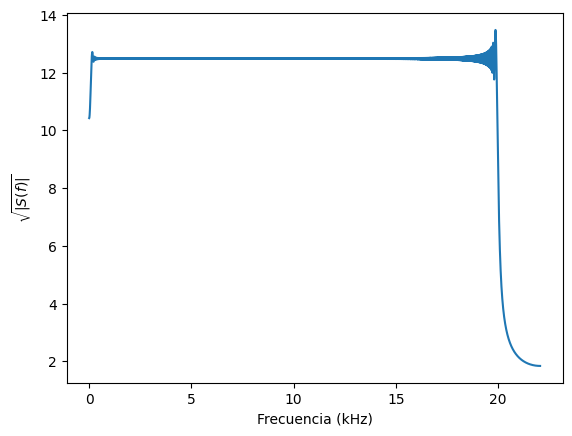

In [2]:
%pylab inline
from scipy.io import wavfile
from IPython.display import Audio
import numpy as np

def plotSpecgram(x,Fs,fMax=None):
    # graficar el espectrograma
    fig, ax = pylab.subplots(nrows=1)
    ax.specgram(x, NFFT=1024, Fs=Fs, noverlap=900)
    pylab.xlabel('Tiempo (s)')
    pylab.ylabel('Frecuencia (Hz)')
    if fMax != None:
        pylab.ylim([0,fMax])
    pylab.show()
    
def plotFFT(x,Fs,xlim=None):
    pylab.figure()
    N2=int(len(x)/2)
    F = np.linspace(0,Fs/2,N2)/1e3
    X = np.sqrt(np.abs(np.fft.fft(x)[0:N2]))
    pylab.plot(F, X)
    X[0] = 0 # remover el valor 0 que contiene el promedio de la energía de la magnitud espectral
    pylab.xlabel('Frecuencia (kHz)')
    pylab.ylabel('$\sqrt{|S(f)|}$')
    if xlim != None:
        pylab.xlim(xlim)
    pylab.show()

rango = [20, 20e3] # el rango promedio de audicion humano en Hz
Fs = 44.1 * 1e3 # la tasa de muestreo de los equipos comerciales
T = 1.0 # segundos (t1-t0)

N = int(T*Fs)
n = np.arange(0,N)
F0 = (rango[1]-rango[0])*n/N + rango[0]

x = np.sin(2*np.pi*F0/(2*Fs)*n) # f=F0/Fs: frecuencia discreta

plotSpecgram(x,Fs)
plotFFT(x,Fs)

wavfile.write('/tmp/barrido.wav',int(Fs),x.astype(np.float32))
Audio(x, rate=Fs) 

El espectrograma muestra que el barrido va de los $0.02$ kHz a los $20$ kHz como se deseaba. Asimismo, la magnitud espectral muestra una recta horizontal casi en todo el rango, indicando que todas las frecuencias están presentes.

Antes de usar 128 kpbs, procedemos a codificar y decodificar el barrido de frecuencias usando Opus a una tasa de bits de 8 kbps para comprobar la distorsión de la señal (la misma tasa empleada en una videollamada entre dos personas)[12]. 

In [4]:
def readPlayVisualizeFile(inputFile,fMax=None):
    fs, x = wavfile.read(inputFile)
    y = np.array(x)/max(x)
    if None==fMax:
        plotSpecgram(x,fs)
    else:
        plotSpecgram(x,fs,fMax)
    return fs, x

#!sudo apt-get install ffmpeg, opus-tools
!ffmpeg -loglevel error -y -i /tmp/barrido.wav -qscale 0 /tmp/wavRaw.wav
!opusenc --quiet --bitrate 8 /tmp/wavRaw.wav /tmp/opusEnc.opus
!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav

Fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x,Fs)

Audio(x, rate=Fs)

/bin/bash: línea 1: ffmpeg: orden no encontrada
/bin/bash: línea 1: opusenc: orden no encontrada
/bin/bash: línea 1: opusdec: orden no encontrada


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/opusDec.wav'

El espectrograma muestra que la energía del rango $[0.02,1.0]$ kHz se mantiene, pero se observa que no es plano, por lo que hubo alguna distorsión. Además, a partir de los casi 5 kHz el barrido de frecuencia se pliega, en un efecto llamado _aliasing_, lo que produce que veamos frecuencias que en realidad no existen, esto podría afectar la calidad del clasificador. Para mitigar el efecto del aliasing se podría emplear un filtro pasa-bajas con frecuencia de corte 5 kHz antes de realizar la compresión. Por su parte, la magnitud espectral muestra que a partir de los 5 kHz las frecuencias altas son atenuadas. 

Probemos ahora con 128 kbps (fullband stereo) a ver si la calidad mejora [12]. 

In [ ]:
!ffmpeg -loglevel error -y -i /tmp/barrido.wav -qscale 0 /tmp/wavRaw.wav # opus-tools
!opusenc --quiet --bitrate 128 /tmp/wavRaw.wav /tmp/opusEnc.opus
!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav

Fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x,Fs)

Audio(x, rate=Fs)

En efecto, la calidad del espectro ha mejorado. El espectrograma sigue mostrando que hay cierto efecto aliasing pero con bastante menor energía, lo cual favorable; y además, los artefactos introducidos no afectan el rango $[0.02,20]$ kHz (hay cierta distorsión mínima luego de los 10 kHz, pero es acotada en $\pm 0.5$) kHz. La magnitud espectral muestra una recta horizontal similar a la que vimos con la señal cruda. Por lo que podemos decir que con full-band se obtiene una menor distorsión visible (es necesario cuantificar esta distorsión). 

**Nota:** En este punto valdría la pena preguntarse cuál de los tres métodos de Opus realizó la compresión y si los resultados variarían en caso de que se fuerce algún método en particular (SILK, CELT o el híbrido). 

## Caso de prueba 2

Para el caso de prueba 2, podemos construir una señal de dos tonos como sigue:

In [ ]:
y = 0.1*np.sin(2*np.pi*595/Fs*n) + np.sin(2*np.pi*605/Fs*n) 
plotSpecgram(y,Fs)
plotFFT(y,Fs,xlim=[500/1e3,700/1e3])

wavfile.write('/tmp/enmascaramiento.wav',int(Fs),y.astype(np.float32))
Audio(y, rate=Fs)

Ahora procedemos a realizar la compresión y de-compresión a una tasa de 8 kbps:

In [ ]:
!ffmpeg -loglevel error -y -i /tmp/enmascaramiento.wav -qscale 0 /tmp/wavRaw.wav # opus-tools
!opusenc --quiet --bitrate 8 /tmp/wavRaw.wav /tmp/opusEnc.opus
!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav

Fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x,Fs,xlim=[500/1e3,700/1e3])

Audio(x, rate=Fs)

El espectrograma muestra que hay información nueva a partir de los 5 kHz que no contenía la grabación original. Esto no parece ser producto de un aliasing sino de información agregada por el Opus, y que podría eliminarse  usando un filtrado pasa bajas post-procesamiento. Se observa que el tono de $0.605$ kHz sigue siendo dominante y que el de $0.595$ kHz ha sido enmascarado completamente. Veamos qué pasa con 128 kbps:

In [ ]:
!ffmpeg -loglevel error -y -i /tmp/enmascaramiento.wav -qscale 0 /tmp/wavRaw.wav # opus-tools
!opusenc --quiet --bitrate 128 /tmp/wavRaw.wav /tmp/opusEnc.opus
!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav

Fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x,Fs,xlim=[500/1e3,700/1e3])

Audio(x, rate=Fs)

Aún se observan información que no existía y el enmascaramiento se ha revertido. De nuevo, lo que se puede hacer en este caso es aplicar un filtro pasa-bajas para atenuar la información extra en el rango $[5,20]$ kHz [18].  

In [ ]:
from scipy import signal

sos = signal.butter(30, 2500, 'lp', fs=Fs, output='sos')
y = signal.sosfilt(sos, x)
plotSpecgram(y,Fs)

plotFFT(y,Fs,xlim=[500/1e3,700/1e3])

Audio(y, rate=Fs)

Aún queda alguna información extra que podría removerse usando un filtrado mejor, pero un buen algoritmo de reconocimiento de patrones debería ser capaz de tolerar cierto nivel de ruido.

## Caso de prueba 3

Procedemos ahora a codificar y decodificar una grabación real tomada de la _Respiratory Sound Database_ usando Opus con la misma tasa de bits de 8 kbps [16]. La grabación está en formato crudo y corresponde a un paciente femenina de 75 años auscultada en la traquea con un micrófono estereo AKG C417L.

**Nota: a partir de este momento se recomienda usar audífonos.**

In [ ]:
Fs, x = readPlayVisualizeFile('./wav/107_3p2_Tc_mc_AKGC417L_2.wav')
plotFFT(x,Fs)

Audio(x, rate=Fs)

Observamos que hay energía alta en el rango $[0,1.5]$ kHz y otra menor en $[7.5,9.5]$ kHz. La primera parece corresponder a los sonidos naturales del cuerpo, la segundo para más bien una frecuencia parásita que podría haberse colado al momento de realizar la grabación (el cuerpo humano no produce tonos constantes y puros como los que se observan después de los $7.5$ kHz).

In [ ]:
# Opus
!ffmpeg -loglevel error -y -i ./wav/107_3p2_Tc_mc_AKGC417L_2.wav -qscale 0 /tmp/wavRaw.wav # same quality
!opusenc --quiet --bitrate 8 /tmp/wavRaw.wav /tmp/opusEnc.opus
!opusdec --quiet /tmp/opusEnc.opus /tmp/opusDec.wav

Fs, x = readPlayVisualizeFile('/tmp/opusDec.wav')
plotFFT(x,Fs)

Audio(x, rate=Fs)

El espectrograma muestra que la energía un poco antes de los 5 kHz fue atenuada, pero ya descubrimos que esto no importa tanto pues se sale del rango objetivo en los $[0.02,1.0]$ kHz. Lo más importante parece ser que las frecuencias están inalterada en el rango deseado. La magnitud espectral muestra un espectro limpio.

# 4 Conclusiones

Acabamos de explicar que el códec Opus es un algoritmo de compresión de audio "con pérdida", lo que significa que elimina las frecuencias inaudibles por el oído humano para disminuir el tamaño del audio a transmitir y esto puede perjudicar la labor de los algoritmos de reconocimiento de patrones de clasificar sonidos captados por un estetoscopio digital. Mostramos que la solución de transmitir audio crudo en una videollamada tiene la desventaja de que puede consumir más ancho de banda e interrumpir la transmisión del video. Esto no solo es contraproducente, sino que también complica la interacción del usuario con el sistema porque se introduce un modo "estetoscopio". Confirmamos que el Opus distorsiona visiblemente el espectro del audio cuando se usan una tasa de bits baja de 8 kbps, pero con una tasa de bits alta de 128 kbps, la distorsión es baja. También vimos que las frecuencias introducidas a partir de los 5 kHz pueden atenuarse usando un filtrado pasa-bajas.  

Como trabajo futuro, se podría investigar un método para cuantificar la distorsión apreciada en los casos de prueba propuestos y contemplar más casos de prueba (por ejemplo, para el enmascaramiento temporal y evaluar una colección de sonidos). También se podría entrenar y evaluar un clasificador para determinar cómo el ruido puede afectar sus diagnósticos.

# Notas
<p id="footnote-1"><sup>1</sup>: De acuerdo a la sugerencia de Arturo Camacho, dado que el contenido frecuencial está por debajo de los 1 kHz y suponiendo que los algoritmos de reconocimiento de patrones puedan trabajar bien en el rango $[0,1]$ kHz, también se podría enviar, por aparte, el audio del estetoscopio en formato crudo. De acuerdo al teorema de Nyquist, esto significaría usar una tasa de muestreo de 2 kHz, lo que en términos de Mbps correspondería a consumir $0,06~\text{Mbps}$ cada segundo ($1~\text{canal} \cdot 2000~\text{Hz} \cdot 32~\text{bits de cuantización } \cdot (1024^{-2})$). Algo factible que no afectaría la calidad de la videollamada.</p>
<p id="footnote-1"><sup>2</sup>: También podría haberse usado ruido blanco en lugar de un barrido de frecuencias.


# Referencias
1. Colaboradores de Wikipedia. Códec de audio [en línea]. Wikipedia, La enciclopedia libre, 2020 [fecha de consulta: 4 de noviembre del 2020]. Disponible en <https://es.wikipedia.org/w/index.php?title=C%C3%B3dec_de_audio&oldid=129362034>. 
2. Hong  Kong  Polytechnic  University. Department of Electronic and Information Engineering. Perceptual Coding and MP3. Disponible en <http://www.eie.polyu.edu.hk/~enyhchan/DAP-lab-PModel-v3.pdf>.
3. López Monfort José Javier. Opus codec | 22/23 | UPV. Universitat Politècnica de València - UPV. Disponible en <https://youtu.be/2-yv1bCDL94>. 
4. Wikipedia contributors. (2020, October 11). SILK. In Wikipedia, The Free Encyclopedia. Retrieved 15:18, November 8, 2020, from https://en.wikipedia.org/w/index.php?title=SILK&oldid=982904860
5. Wikipedia contributors. (2020, November 2). Linear predictive coding. In Wikipedia, The Free Encyclopedia. Retrieved 15:22, November 8, 2020, from https://en.wikipedia.org/w/index.php?title=Linear_predictive_coding&oldid=986664067
6. EPFL. Room impulse responses. Ultima vez consultado el 27 Dec 2020 en: https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Room_Acoustics/Room%20Impulse%20Response.ipynb
7. López Monfort José Javier. Enmascaramiento Temporal | 4/23 | UPV. Disponible en <https://youtu.be/7NQvDoZMBM8> (consultado por última vez el 3 de Enero de 2021).
8. International Telecomunication Union (ITU-T). P.800.1, MOS.
9. Julius O. Smith III, Jonathan S. Abel. Equivalent Rectangular Bandwidth. Center for Computer Research in Music and Acoustics (CCRMA), Stanford University. Disponible en <https://ccrma.stanford.edu/~jos/bbt/Equivalent_Rectangular_Bandwidth.html> (consultado por última vez el 5 de Enero de 2021).
10. LCAV. Python MP3 encoder. Disponible en <https://github.com/LCAV/MP3Lab/blob/master/mp3python.ipynb> (consultado por última vez el 6 de Enero de 2021).
11. XIPH ORG. OpusFAQ. Disponible en <https://wiki.xiph.org/OpusFAQ#Why_not_keep_the_SILK_and_CELT_codecs_separate.3F> (consultado por última vez el 6 de Enero de 2021).
12. Tyler Abbott. How Much Data Does a Zoom Meeting Use?. Reviews ORG. Disponible en <https://www.reviews.org/internet-service/how-much-data-does-zoom-use/> (consultado por última vez el 16 de Enero de 2021).
13. Xiph.Org Foundation. The Opus Codec. 135th AES Convention2013 October 17–20  New York, USA. Disponible en <https://arxiv.org/pdf/1602.04845.pdf> (consultado por última vez el 21 de Enero de 2021).
14. GROSS, V., DITTMAR, A., PENZEL, T., SCHÜTTLER, F., & von WICHERT, P. (2000). The Relationship between Normal Lung Sounds, Age, and Gender. American Journal of Respiratory and Critical Care Medicine, 162(3), 905–909. https://doi.org/10.1164/ajrccm.162.3.9905104 (consultado por última vez el 23 de Enero de 2021).
15. McGee, S. (2018). Chapter 39 - Auscultation of the Heart: General Principles. In S. McGee (Ed.), Evidence-Based Physical Diagnosis (Fourth Edition) (Fourth Edition, pp. 327-332.e1). Elsevier. https://doi.org/https://doi.org/10.1016/B978-0-323-39276-1.00039-1 (consultado por última vez el 23 de Enero de 2021).
16. Rocha BM, Filos D, Mendes L, Vogiatzis I, Perantoni E, Kaimakamis E, Natsiavas P, Oliveira A, Jácome C, Marques A, Paiva RP (2018). Α Respiratory Sound Database for the Development of Automated Classification. In Precision Medicine Powered by pHealth and Connected Health (pp. 51-55). Springer, Singapore. Disponible en: <https://www.kaggle.com/vbookshelf/respiratory-sound-database> (consultado por última vez el 24 de Enero de 2021).
17. Carlos Cordero Pérez. Claro con precios rebajados de Internet móvil prepago en Panamá.Tecnología, El Financiero. Disponible en: <http://wvw.elfinancierocr.com/ef_archivo/2010/junio/27/tecnologia2420649.html> (consultado por última vez el 30 de Enero de 2021).
18. The SciPy community. scipy.signal.butter. Disponible en: <https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html> (consultado por última vez el 30 de Enero de 2021).
19. Jang-Jaccard, J., Nepal, S., Celler, B. et al. WebRTC-based video conferencing service for telehealth. Computing 98, 169–193 (2016). https://doi.org/10.1007/s00607-014-0429-2

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2020,
  author = {Juan M. Fonseca-Solís},
  title = {Evaluación de la pérdida de calidad del audio usando el codec Opus en tareas de auscultación remota},
  year = 2020,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.evaluacionPerdidaCalidadAudioOpus.html},
  urldate = {}
}
```